In [90]:
import os
from glob import glob
from pathlib import Path

import geopandas as gpd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import json

from IPython.display import display

In [93]:
import src.elevation as elevation
import src.clean as clean
import src.plot as plot

In [104]:
# Paths
shapefile_bisse = os.path.join("data", "bisses_geodata", "bisses.shp")
dem_folder = os.path.join("data", "DEM")  # Folder containing multiple DEM files
data = "data"

# ! read from json file
# path of file from field results
PATH = os.path.join(data, "bisses")
print(PATH)
# get all json of bisse
folders = [f.path for f in os.scandir(PATH) if f.is_dir()]
files = [y for x in os.walk(PATH) for y in glob(os.path.join(x[0], "*.json"))]
filenames = [Path(path).stem for path in files]

# ! check if file is missing for a folder
# all bisse where data has been collected in a json
bisses_dict = dict(zip(filenames, files))
print(bisses_dict)
# this is the variable the interface will change
bisse_select = "clavau"

# json holding the info for that specific bisse
# ie path, sample dir, date, ect...
with open(bisses_dict[bisse_select], "r") as file:
    bisse_json = json.load(file)

# json holding info for each entry that is common to all bisses
with open(os.path.join(data, "_template", "donnees.json"), "r") as file:
    generic_json = json.load(file)
clean.generic_json = generic_json

# display(bisse_json)
# bisse_json = bisses_json[bisse_select]

data\bisses
{'clavau': 'data\\bisses\\clavau\\clavau.json', 'plot': 'data\\bisses\\clavau\\touristique\\plot.json'}


In [95]:
# Load the line shapefile
bisses_gdf = gpd.read_file(shapefile_bisse).to_crs("EPSG:2056")  # to swiss projection

# get only the bisse we want
bisse_select_gdf = bisses_gdf[bisses_gdf["Nom_bisse"] == bisse_json["nom_imventaire"]]
# extract the linestring
bisse_line = bisse_select_gdf.loc[:, "geometry"].iloc[0]

bisse_profile = elevation.get_elevation_profile(bisse_line, dem_folder=dem_folder)

# cleaning data referenced in json

In [5]:
path_clavau = os.path.normpath("data/bisses/clavau")

#! need to do that for all couches
clean.clean_list_json(
    bisse_json,
    "liste_touristique",
    bisse_line,
    "data/bisses/clavau/touristique",
)
clean.clean_list_json(
    bisse_json,
    "liste_environnement",
    bisse_line,
    "data/bisses/clavau/environnement",
)

d:\Programme\miniconda3\envs\bisses\Lib\site-packages\pyogrio\raw.py:198: UserWarning: Measured (M) geometry types are not supported. Original type 'PointM' is converted to 'Point'
  return ogr_read(


# plotting

In [6]:
import random

with open(os.path.join("data/bisses/clavau/environnement", "plot.json"), "r") as file:
    plot_env = json.load(file)

with open(os.path.join("data/bisses/clavau/touristique", "plot.json"), "r") as file:
    plot_tour = json.load(file)

to_plot = []
to_plot.append(random.sample(list(plot_env.values()), k=1))
to_plot.append(random.sample(list(plot_tour.values()), k=1))
to_plot = [x for xs in to_plot for x in xs]
print(to_plot)

[{'nom_indice': 'Biotopes', 'type_donnee': 'section', 'format_donnee': ['categorique'], 'drop_down': 'path/to/file', 'col': [['val_av', 'val_ap']], 'path': 'data\\bisses\\clavau\\environnement\\Biotopes\\biotope.csv'}, {'nom_indice': 'Panneaux information', 'type_donnee': 'point', 'format_donnee': ['categorique'], 'drop_down': 'path/to/file', 'col': ['type'], 'path': 'data\\bisses\\clavau\\touristique\\Panneaux information\\didact.csv'}]


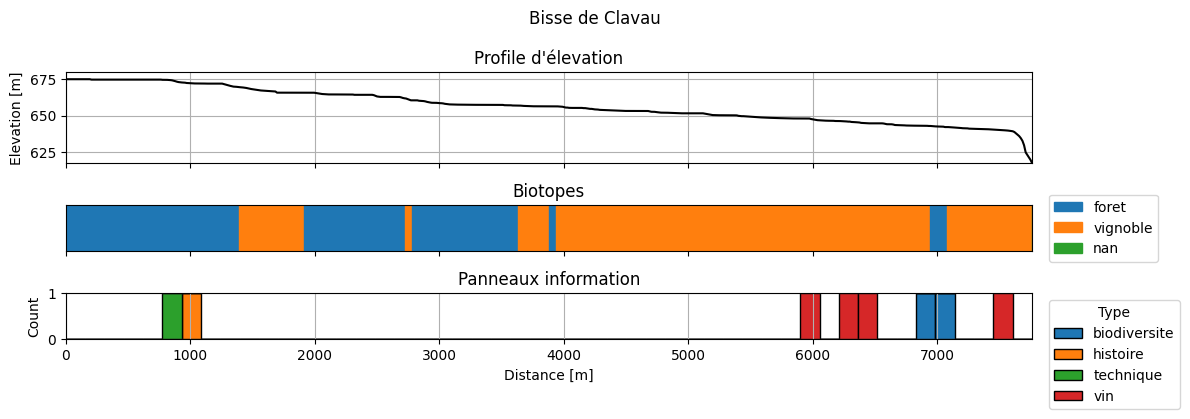

In [7]:
number_of_functions = 2

height_ratio = {"height_ratios": [2] + [1] * number_of_functions}
fig, axs = plt.subplots(
    nrows=number_of_functions + 1,
    figsize=(12, 2 * number_of_functions),
    sharex=True,
    gridspec_kw=height_ratio,
)

plot.plot_elevation(axs[0], bisse_profile)
axs[0].set_title("Profile d'élevation")

for i, indicateur in enumerate(to_plot):
    data = pd.read_csv(indicateur["path"])

    if indicateur["type_donnee"] == "section":
        plot.plot_sections(axs[i + 1], bisse_profile, data)
    elif indicateur["type_donnee"] == "point":
        plot.plot_point_data(axs[i + 1], bisse_profile, data, num_bins=50)
    elif indicateur["type_donnee"] == "autre":
        print("can't find implementation of plot for that type of data")
    else:
        print("Unknown data type")

    axs[i + 1].set_title(indicateur["nom_indice"])

axs[-1].set_xlabel("Distance [m]")

fig.suptitle("Bisse de Clavau")
plt.tight_layout()
plt.show()

# Plotly graphs


In [74]:
# Use a constant y value for all rows to simulate a horizontal "banner"
import pandas as pd

df = pd.read_csv("data/bisses/clavau/environnement/Biotopes/biotope.csv")

# Create a column for the length of each segment
df["length"] = df["end_dist_m"] - df["start_dist_m"]

In [75]:
display(df)

,Unnamed: 0,value,start_dist_m,end_dist_m,comment,length
0,0,foret,0.000000,1391.082872,"[None, None]",1391.082872
1,1,vignoble,1391.082872,1917.071386,"[None, 'tunnel']",525.988514
2,2,foret,1917.071386,2726.340603,"['1954', None]",809.269217
3,3,vignoble,2726.340603,2778.276409,[None],51.935805
4,4,foret,2778.276409,3631.431592,[None],853.155184
5,5,vignoble,3631.431592,3879.987607,[None],248.556014
6,6,foret,3879.987607,3939.957112,['revet:terre conduite apres'],59.969506
7,7,vignoble,3939.957112,6939.975439,"[None, None, None, None, 'papillons fleurs en ...",3000.018327
8,8,foret,6939.975439,7079.354765,"['panneau uvette', None]",139.379326
9,9,vignoble,7079.354765,7763.530635,"[None, None, None, None]",684.175871


In [86]:
import plotly.graph_objects as go
import plotly.express as px
import matplotlib.pyplot as plt
from matplotlib.colors import to_hex

# Auto-assign colors for categories


unique_vals = df["value"].unique()
# cmap = plt.get_cmap("tab10")
cmap = px.colors.qualitative.G10
# colors = {val: to_hex(cmap(i)) for i, val in enumerate(unique_vals)}
colors = {val: cmap[i % len(cmap)] for i, val in enumerate(unique_vals)}

fig = go.Figure()

already_legend = []

for index, sec in df.iterrows():
    leg = False
    if sec["value"] not in already_legend:
        already_legend.append(sec["value"])
        leg = True
    fig.add_trace(
        go.Bar(
            x=[sec["length"]],
            y=[0],
            orientation="h",
            marker=dict(
                color=colors[sec["value"]],
                line=dict(color="rgb(0,0,0)", width=0),
            ),
            # marker_color = ,
            name=sec["value"],
            showlegend=leg,
        )
    )

fig.update_layout(
    xaxis=dict(
        showgrid=False,
        showline=True,
        showticklabels=True,
        zeroline=False,
        # domain=[0.15, 1],
        range=[0, 7700],
    ),
    yaxis=dict(
        showgrid=False,
        showline=False,
        showticklabels=False,
        zeroline=False,
        # range=[-0.1, 0.1]
    ),
    # barmode="stack",  # makes it a stacked graph
    barmode="relative",  # makes it a stacked graph
    # paper_bgcolor="rgb(248, 248, 255)",
    # plot_bgcolor="rgb(248, 248, 255)",
    # margin=dict(l=120, r=10, t=140, b=80),
    showlegend=True,
    legend=dict(
        itemclick=False,  # Disable click interactions in the legend
        itemdoubleclick=False,  # Disable double-click interactions in the legend
    ),
    height=300,
    dragmode=False,
)

fig.update_traces(marker_line_width=0, width=0.5)

config = {
    "staticPlot": False,  # Make the plot interactive
    "displayModeBar": False,  # Hide the mode bar
    "scrollZoom": False,  # Disable zooming with the scroll wheel
    "doubleClick": False,  # Disable resetting the view on double-click
    "displaylogo": False,  # Hide the Plotly logo
}

fig.show(config=config)

## Elevation profile

In [ ]:
import plotly.graph_objects as go


def plot_elevation(fig, profile_df):
    """
    Plot elevation profile using Plotly.

    Parameters:s
        profile_df : DataFrame with 'dist_m' (distance) and 'elevation' columns
    """

    # Add elevation line
    fig.add_trace(
        go.Scatter(
            x=profile_df["dist_m"],
            y=profile_df["elevation"],
            mode="lines",
            name="Elevation",
            line=dict(color="black"),
        )
    )

    # Update layout
    fig.update_layout(
        title="Elevation Profile",
        xaxis=dict(
            title="Distance [m]",
            range=[profile_df["dist_m"].min(), profile_df["dist_m"].max()],
            showgrid=True,
        ),
        yaxis=dict(
            title="Elevation [m]",
            range=[profile_df["elevation"].min(), profile_df["elevation"].max() + 5],
            showgrid=True,
        ),
        template="plotly_white",
        height=300,
    )

    # Show the plot
    fig.show()

In [ ]:
fig = go.Figure()
plot_elevation(fig, bisse_profile)

In [107]:
import plotly.graph_objects as go
import numpy as np
import pandas as pd


def plot_point_data(profile_df, type_df, num_bins=20):
    """
    Plot point data as a stacked bar chart using Plotly.

    Parameters:
        profile_df : DataFrame with 'dist_m' (distance) column
        type_df : DataFrame with 'dist_m' (distance) and 'type' columns
        num_bins : Number of bins along the distance axis
    """
    # Create bins
    dist_min, dist_max = profile_df["dist_m"].min(), profile_df["dist_m"].max()
    bins = np.linspace(dist_min, dist_max, num_bins + 1)
    bin_centers = (bins[:-1] + bins[1:]) / 2
    bin_labels = list(range(num_bins))

    # Bin the data
    type_df = type_df.copy()
    type_df["bin"] = pd.cut(
        type_df["dist_m"], bins=bins, labels=False, include_lowest=True
    )

    # Count types per bin
    counts = type_df.groupby(["bin", "type"]).size().unstack(fill_value=0)
    counts = counts.reindex(index=bin_labels, fill_value=0)  # Fill missing bins

    # Colors
    types = counts.columns
    colors = px.colors.qualitative.Set3  # Use a Plotly color palette
    type_colors = {t: colors[i % len(colors)] for i, t in enumerate(types)}

    # Create the figure
    fig = go.Figure()

    # Stacked bar chart
    bottoms = np.zeros(len(counts))
    for t in types:
        values = counts[t].values
        fig.add_trace(
            go.Bar(
                x=bin_centers,
                y=values,
                name=t,
                marker=dict(color=type_colors[t]),
            )
        )
        bottoms += values

    # Update layout
    fig.update_layout(
        barmode="stack",
        title="Point Data Distribution",
        xaxis=dict(
            title="Distance [m]",
            range=[dist_min, dist_max],
            showgrid=True,
        ),
        yaxis=dict(
            title="Count",
            showgrid=True,
        ),
        legend=dict(title="Type"),
        template="plotly_white",
        height=400,
    )

    # Show the plot
    fig.show()

In [ ]:
data = pd.read_csv("data/bisses/clavau/touristique/Panneaux information/didact.csv")

# Create the figure
fig = go.Figure()

plot_point_data(bisse_profile, data, 50)